In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from keras.callbacks import ModelCheckpoint
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras import regularizers

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 10)

Using TensorFlow backend.


In [3]:
ONE_DAY_LAGS = 288
DATA_PATH = '/mnt/sdc1/inon/norrecampus/data/by_place_5min'
EXAMPLE_PLACE_ID = 'ChIJZaR1M1hSUkYRxP0WkwYYy_k'

THRESHOLD_HIGH_OUTLIER = 110
LOSS = 'mse'
MINI_BATCH_SIZE = 512
NUM_EPOCHS = 100
VALIDATION_SPLIT = 0.2
NUM_LAGS = 12
LSTM_STATE_SIZE = NUM_LAGS
SPLIT_DATE = '2015-06-01'

In [4]:
def split_timestamp(ser):
    return pd\
        .DataFrame(ser)\
        .assign(day_of_week=lambda df: df.index.dayofweek, time_of_day=lambda df: df.index.time)\
        .reset_index()

In [5]:
def compute_error_statistics_and_plot_15jan2017(errors_df):
    errors_df.drop('error', axis=1)[ONE_DAY_LAGS * 15:ONE_DAY_LAGS * 16].plot()
    plt.legend()
    
    abs_errors = errors_df.error.abs()
    abs_errors_normalized = abs_errors / errors_df.flow_decile_true
    return {
        'corr': np.corrcoef(errors_df.flow_decile_predicted, errors_df.flow_decile_true)[0, 1],
        'mae': np.mean(abs_errors),
        'mape': np.mean(abs_errors_normalized),
        'mse': np.mean(abs_errors ** 2),
        'msne': np.mean(abs_errors_normalized ** 2),
        'rae': np.sum(abs_errors) / np.sum(np.abs(errors_df.flow_decile_true - np.mean(errors_df.flow_decile_true))),
        'rmse': np.sqrt(np.mean(abs_errors ** 2)),
        'rmsne': np.sqrt(np.mean(abs_errors_normalized ** 2)),
        'r2': max(0, 1 - np.sum(abs_errors ** 2) / np.sum((errors_df.flow_decile_true - np.mean(errors_df.flow_decile_true)) ** 2))
    }

In [6]:
def binary_encode(flow_decile):
    return ','.join('0' * (9 - int(flow_decile)) + '1' * (int(flow_decile) + 1))[::-1]

assert binary_encode(0) == '1,0,0,0,0,0,0,0,0,0'
assert binary_encode(9) == '1,1,1,1,1,1,1,1,1,1'
assert binary_encode(3) == '1,1,1,1,0,0,0,0,0,0'

In [7]:
def binary_decode(nn_result, threshold):
    for i in range(len(nn_result)):
        if nn_result[i] < threshold:
            return i - 1
    return len(nn_result) - 1

for i in range(10):
    assert binary_decode([1] * (i + 1) + [0] * (9 - i), 1) == i
assert binary_decode([0.6,0.7,0.55,0.51,0.2,1,0,0,0,1], 0.5) == 3

In [12]:
class LearnerForFlowDecileOfOneSegmentWithoutDetrending(object):
    def __init__(self,
                 threshold_ordinal_regression,
                 loss,
                 place_id, 
                 mini_batch_size,
                 num_epochs,
                 validation_split,
                 num_lags,
                 lstm_state_size,
                 split_date):
        self.df = None
        self.model = None
        
        self.threshold_ordinal_regression = threshold_ordinal_regression
        self.loss = loss
        self.place_id = place_id
        self.mini_batch_size = mini_batch_size
        self.num_epochs = num_epochs
        self.validation_split = validation_split
        self.num_lags = num_lags
        self.lstm_state_size = lstm_state_size
        self.split_date = split_date
        self.checkpoint_basename = 'ordinal_regression_flow_%s.best.hdf5' % self.place_id      
    
    def baseline_lr(self):
        X_train, Y_train, X_test, Y_test = learner._split_to_train_and_test()
        trained_lr = LinearRegression(fit_intercept=False).fit(X_train.values, Y_train.values)
        lr_predictions = trained_lr.predict(X_test).round(0)
        errors_df = self._individual_errors_without_interpolated_values(lr_predictions)
        return compute_error_statistics_and_plot_15jan2017(errors_df)
                    
    def _imputation_for_missing_values(self, ser):
        missing_timestamps = pd\
            .date_range(min(ser.index.date), max(ser.index.date) + timedelta(days=1), freq='5T')\
            .difference(ser.index)
        df_with_nans_where_missing = pd.DataFrame(ser)\
            .join(pd.DataFrame(index=missing_timestamps), how='outer')\
            .assign(original_value=lambda df: df.iloc[:, 0])
        df_interpolated = df_with_nans_where_missing\
            .iloc[:, 0]\
            .interpolate()\
            .round()\
            .astype(np.int64)\
            .to_frame()\
            .assign(original_value=df_with_nans_where_missing.original_value)\
            .assign(is_interpolated=lambda df: df.iloc[:, 0] != df.iloc[:, 1])
        assert all(df_interpolated.flow_decile.isin(range(10)))
        return df_interpolated
        
    def _get_flows(self):
        if self.df is None:
            self.df = pd.read_csv(
                os.path.join(DATA_PATH, self.place_id + '.csv'),
                parse_dates=['start_interval_s', 'end_interval_s']\
            )[lambda df: df.start_interval_s >= '2015-01-01']\
            .rename(columns={'start_interval_s': 't', 'flow_bucket': 'flow_decile'})\
            .set_index('t')\
            .flow_decile
        return self.df

    def _split_to_train_and_test(self):
        flows_interpolated = self._imputation_for_missing_values(self._get_flows()).flow_decile
        lags = pd.concat([flows_interpolated.shift(x) for x in range(self.num_lags + 1)], axis=1)[self.num_lags:]
        train = lags[lags.index < self.split_date]
        X_train = train.iloc[:, 1:]
        Y_train = train.iloc[:, 0]
        test = lags[lags.index >= self.split_date]
        X_test = test.iloc[:, 1:]
        Y_test = test.iloc[:, 0]
        return X_train, Y_train, X_test, Y_test
    
    def _get_train_and_test_inputs(self):
        X_train, Y_train, X_test, Y_test = self._split_to_train_and_test()
        
        def bin_enc_ser(ser):
            return np.array(
                ser.apply(binary_encode).str.split(',', expand=True).astype(int))\
                [:, :, np.newaxis]

        def bin_enc(inp):
            return np.concatenate([bin_enc_ser(inp.iloc[:, i]) for i in range(inp.shape[1])], axis=2)\
                .swapaxes(1, 2)

        return \
            bin_enc(X_train), bin_enc_ser(Y_train).squeeze(axis=2), \
            bin_enc(X_test), bin_enc_ser(Y_test).squeeze(axis=2) \

    def _build_model(self):
        # TODO: better weights initialization
        self.model = Sequential()
        self.model.add(LSTM(self.lstm_state_size, input_shape=(self.num_lags, 10), return_sequences=False))
        # model.add(Dropout(0.2))
        #model.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.00001)))
        self.model.add(Dense(units=10, activation="sigmoid"))
        self.model.compile(loss=self.loss, optimizer="rmsprop")  # TODO: try adam optimizer too, although rmsprop is the default go-to for RNN
    
    def load_best_model_from_disk(self):
        self._build_model()
        self.model.load_weights(self.checkpoint_basename)
    
    def create_and_train_model(self):
        self._build_model()
        X_train, Y_train, _, _ = self._get_train_and_test_inputs()
        self.model.fit(
            X_train,
            Y_train,
            batch_size=self.mini_batch_size,
            epochs=self.num_epochs,
            validation_split=self.validation_split,
            # checkpoint best model
            callbacks=[ModelCheckpoint(
                self.checkpoint_basename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')],
            verbose=2)
        self.model.load_weights(self.checkpoint_basename)
    
    def predict(self):
        _, _, X_test, _ = self._get_train_and_test_inputs()
        predictions_encoded = self.model.predict(X_test)
        predictions_decoded = np.apply_along_axis(
            lambda prediction: binary_decode(prediction, 0.5), 1, predictions_encoded)
        errors_df = self._individual_errors_without_interpolated_values(predictions_decoded)
        return compute_error_statistics_and_plot_15jan2017(errors_df)
        
    def _individual_errors_without_interpolated_values(self, predictions_decoded):
        _, _, _, Y_test = self._split_to_train_and_test()
        ser_predictions_decoded = pd.Series(predictions_decoded, index=Y_test.index, name='flow_decile')
        interpolated_timestamps = self\
            ._imputation_for_missing_values(self._get_flows())\
            [lambda df: df.is_interpolated]\
            .index
        return Y_test.to_frame()\
            .join(ser_predictions_decoded.to_frame(), lsuffix='_true', rsuffix='_predicted')\
            .loc[lambda df: df.index.difference(interpolated_timestamps)]\
            .assign(error=lambda df: df.flow_decile_true - df.flow_decile_predicted)
                    
learner = LearnerForFlowDecileOfOneSegmentWithoutDetrending(
    threshold_ordinal_regression = 0.5,
    loss=LOSS,
    place_id=EXAMPLE_PLACE_ID, 
    mini_batch_size=MINI_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    validation_split=VALIDATION_SPLIT,
    num_lags=NUM_LAGS,
    lstm_state_size=LSTM_STATE_SIZE,
    split_date=SPLIT_DATE)

In [9]:
learner.create_and_train_model()

Train on 34780 samples, validate on 8696 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.12097, saving model to ordinal_regression_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
 - 3s - loss: 0.1808 - val_loss: 0.1210
Epoch 2/100
Epoch 00002: val_loss improved from 0.12097 to 0.06500, saving model to ordinal_regression_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
 - 2s - loss: 0.0921 - val_loss: 0.0650
Epoch 3/100
Epoch 00003: val_loss improved from 0.06500 to 0.04190, saving model to ordinal_regression_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
 - 2s - loss: 0.0544 - val_loss: 0.0419
Epoch 4/100
Epoch 00004: val_loss improved from 0.04190 to 0.03309, saving model to ordinal_regression_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
 - 2s - loss: 0.0394 - val_loss: 0.0331
Epoch 5/100
Epoch 00005: val_loss improved from 0.03309 to 0.02849, saving model to ordinal_regression_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
 - 2s - loss: 0.0327 - val_loss: 0.0285
Epoch 6/100
Epoch 00006: 

Epoch 00060: val_loss did not improve
 - 2s - loss: 0.0184 - val_loss: 0.0178
Epoch 61/100
Epoch 00061: val_loss did not improve
 - 2s - loss: 0.0184 - val_loss: 0.0177
Epoch 62/100
Epoch 00062: val_loss improved from 0.01770 to 0.01769, saving model to ordinal_regression_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
 - 2s - loss: 0.0184 - val_loss: 0.0177
Epoch 63/100
Epoch 00063: val_loss did not improve
 - 2s - loss: 0.0184 - val_loss: 0.0179
Epoch 64/100
Epoch 00064: val_loss did not improve
 - 2s - loss: 0.0184 - val_loss: 0.0179
Epoch 65/100
Epoch 00065: val_loss did not improve
 - 2s - loss: 0.0183 - val_loss: 0.0179
Epoch 66/100
Epoch 00066: val_loss did not improve
 - 2s - loss: 0.0184 - val_loss: 0.0180
Epoch 67/100
Epoch 00067: val_loss improved from 0.01769 to 0.01761, saving model to ordinal_regression_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
 - 2s - loss: 0.0183 - val_loss: 0.0176
Epoch 68/100
Epoch 00068: val_loss did not improve
 - 2s - loss: 0.0183 - val_loss: 0.0178
Ep

{'corr': 0.95730941106001333,
 'mae': 0.18311548147259862,
 'mape': inf,
 'mse': 0.21717232282048207,
 'msne': inf,
 'r2': 0.91602110530446823,
 'rae': 0.1489412368583907,
 'rmse': 0.46601751342678321,
 'rmsne': inf}

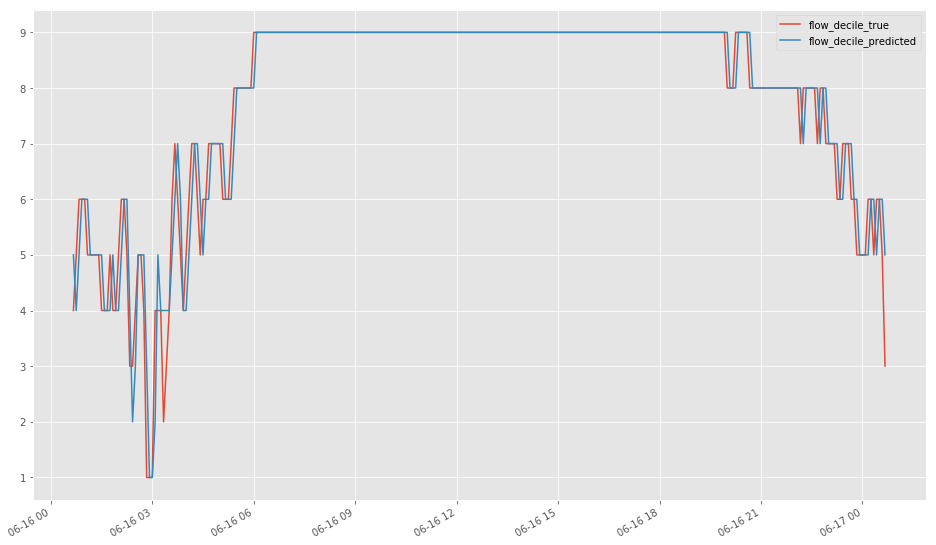

In [10]:
learner.load_best_model_from_disk()
learner.predict()

{'corr': 0.95696141572539839,
 'mae': 0.18335531838349922,
 'mape': inf,
 'mse': 0.22005036575128911,
 'msne': inf,
 'r2': 0.91490818787062356,
 'rae': 0.14913631378944295,
 'rmse': 0.46909526298108056,
 'rmsne': inf}

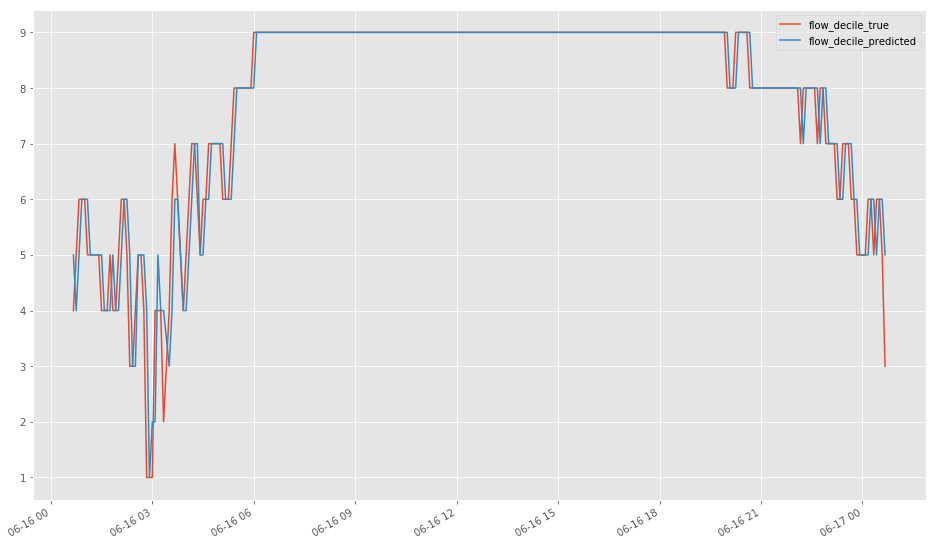

In [13]:
learner.baseline_lr()